# Object segmentation with Region Growing with Shape Prior

Region growing is a classical image segmentation method based on hierarchical region aggregation using local similarity rules. Our proposed method differs from classical region growing in three important aspects. First, it works on the level of superpixels instead of pixels, which leads to a substantial speedup. Second, our method uses learned statistical shape properties which encourage growing leading to plausible shapes. In particular, we use ray features to describe the object boundary. Third, our method can segment multiple objects and ensure that the segmentations do not overlap. The problem is represented as an energy minimization and is solved either greedily, or iteratively using GraphCuts.

Borovec, J., Kybic, J., & Sugimoto, A. (2017). **Region growing using superpixels with learned shape prior.** Journal of Electronic Imaging.
Dvorak, J. et al. (2018). _Volume estimation from single images: an application to pancreatic islets._ Image Analysis & Stereology.

In [1]:
%matplotlib inline
import os, sys, glob
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
from skimage import segmentation as sk_segm
from skimage import io, measure
import matplotlib.pylab as plt

In [2]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import imsegm.utilities.data_io as tl_io
import imsegm.utilities.drawing as tl_visu
import imsegm.superpixels as seg_spx
import imsegm.region_growing as seg_rg
import imsegm.graph_cuts as seg_gc
import imsegm.pipelines as seg_pipe

## Loading data

In [3]:
COLORS = 'bgrmyck'
PATH_IMAGES = os.path.join(tl_io.update_path('data_images'), 'langerhans_islets')
PATH_DATA = tl_io.update_path('data_images', absolute=True)
PATH_OUT = tl_io.update_path('output', absolute=True)
PATH_MEASURED_RAYS = os.path.join(PATH_IMAGES, 'islets_ray-shapes_1400x1050.csv')
print ([os.path.basename(p) for p in glob.glob(os.path.join(PATH_IMAGES, '*')) if os.path.isdir(p)])
# dir_annot = os.path.expanduser('~/Dropbox/Workspace/segment_Medical/Ovary-eggs/mask_2d_slice_complete_ind_egg')

['image_red', 'image', 'binary-masks_1400x', 'binary-masks', 'annot']


In [4]:
DIR_IMAGES = os.path.join(PATH_IMAGES, 'image')
DIR_SEGMS = os.path.join(PATH_IMAGES, 'segm')
DIR_ANNOTS = os.path.join(PATH_IMAGES, 'annot')

## Estimate shape models

In [5]:
def compute_prior_map(cdist, size=(500, 800), step=5):
    prior_map = np.zeros(size)
    centre = np.array(size) / 2
    for i in np.arange(prior_map.shape[0], step=step):
        for j in np.arange(prior_map.shape[1], step=step):
            prior_map[i:i+step, j:j+step] = seg_rg.compute_shape_prior_table_cdf([i, j], cdist, centre, angle_shift=0)
    return prior_map

Visualisation of all normalised Ray features with given angular step.

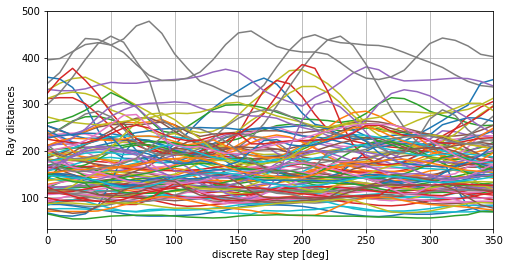

In [7]:
df = pd.read_csv(PATH_MEASURED_RAYS, index_col=0)
list_rays = df.values.tolist()
fig = plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 360, len(list_rays[0]) + 1)[:-1], np.array(list_rays).T, '-')
_= plt.xlim([0, 350]), plt.grid(), plt.xlabel('discrete Ray step [deg]'), plt.ylabel('Ray distances')

### Computing shape prior model

Estimate and exporting model...

In [8]:
model_rg, list_mean_cdf = seg_rg.transform_rays_model_sets_mean_cdf_mixture(list_rays, 5)
# model, list_mean_cdf = tl_rg.transform_rays_model_sets_mean_cdf_kmeans(list_rays, 25)
PATH_MODEL_MIXTURE = os.path.join(PATH_DATA, 'RG2SP_islets_single-model.pkl')

with open(PATH_MODEL_MIXTURE, 'w') as fp:
    pickle.dump({'name': 'set_cdfs', 'cdfs': list_mean_cdf, 'mix_model': model_rg}, fp)

Try to load just exported model to verify that it is readeble.

In [9]:
file_model = pickle.load(open(PATH_MODEL_MIXTURE, 'r'))
print (file_model.keys())
list_mean_cdf = file_model['cdfs']
model_rg = file_model['mix_model']

['mix_model', 'cdfs', 'name']


Visualise the set of components from Mixture model and their back reconstructions

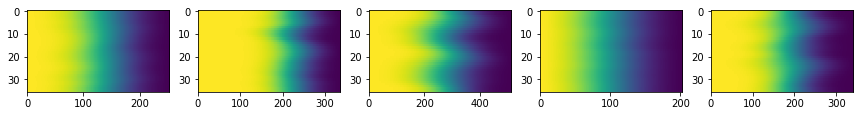

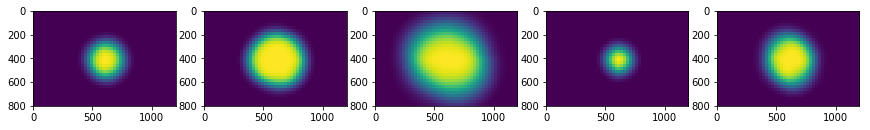

In [12]:
subfig_per_row = 8
subfig_per_col = int(np.ceil(len(list_mean_cdf) / float(subfig_per_row)))
fig = plt.figure(figsize=(3 * subfig_per_row, 1.5 * subfig_per_col))
for i in range(len(list_mean_cdf)):
    plt.subplot(subfig_per_col, subfig_per_row, i+1), plt.imshow(list_mean_cdf[i][1], aspect='auto')
fig = plt.figure(figsize=(3 * subfig_per_row, 2 * subfig_per_col))
for i in range(len(list_mean_cdf)):
    plt.subplot(subfig_per_col, subfig_per_row, i+1)
    plt.imshow(compute_prior_map(list_mean_cdf[i][1], size=(800, 1200), step=25))

## Loading Image

In [13]:
name = 'Lh05-09'
img = io.imread(os.path.join(DIR_IMAGES, name + '.jpg'))
annot = measure.label(io.imread(os.path.join(DIR_ANNOTS, name + '.png')))
centers = np.array([ndimage.measurements.center_of_mass(annot == l) for l in range(1, np.max(annot) + 1)])
centers += (np.random.random(centers.shape) - 0.5) * 100
print ('centres: %s' % repr(centers))
FIG_SIZE = (8. * np.array(img.shape[:2]) / np.max(img.shape))[::-1]

centres: array([[ 513.78095009,  837.2978496 ]])


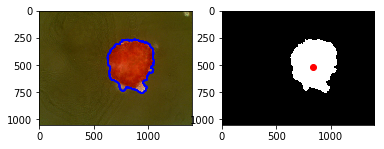

In [15]:
plt.subplot(1, 2, 1)
plt.imshow(img), plt.contour(annot, colors='b')
plt.subplot(1, 2, 2)
plt.imshow(annot, cmap=plt.cm.Greys_r)
plt.plot(centers[:, 1], centers[:, 0], 'or')
_= plt.xlim([0, img.shape[1]]),  plt.ylim([img.shape[0], 0])

### Compute superpixels and probabilities

In [16]:
img_tf = img.copy()
img_tf[:, :, 2] = img_tf[:, :, 0]
SLIC_SIZE = 25
SLIC_REGUL = 0.2
DICT_FEATURES = {'color': ['mean', 'median']}
slic, features = seg_pipe.compute_color2d_superpixels_features(img_tf, dict_features=DICT_FEATURES, sp_size=SLIC_SIZE, sp_regul=SLIC_REGUL)
features = np.nan_to_num(features)
print ('feature space: %s' % repr(features.shape))

model_seg = seg_gc.estim_class_model(features, 2, pca_coef=None, estim_model='GMM', use_scaler=True)
slic_preds = model_seg.predict_proba(features)
print ('prediction shape: %s' % repr(slic_preds.shape))

feature space: (2329, 6)
prediction shape: (2329, 2)

image BG scores: [441.35775946597442, 30.228474053176999]


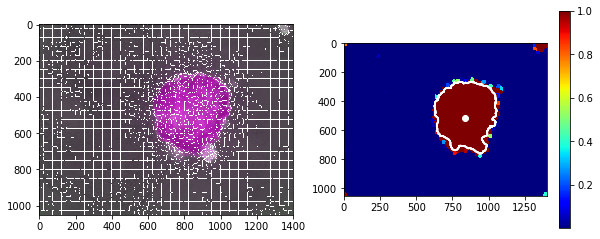

In [17]:
grid_x, grid_y = np.mgrid[0:img.shape[0], 0:img.shape[1]]
grid_x -= int(img.shape[0] / 2.)
grid_y -= int(img.shape[1] / 2.)
dist_center = np.sqrt(grid_x ** 2 + grid_y ** 2)
img_bg_score = [np.mean(dist_center * slic_preds[:, i][slic]) for i in range(slic_preds.shape[1])]
slic_prob_fg = slic_preds[:, np.argmin(img_bg_score)]
print ('image BG scores: %s' % repr(img_bg_score))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1), plt.imshow(sk_segm.mark_boundaries(img_tf, slic, color=(1, 1, 1)))

plt.subplot(1, 2, 2)
plt.imshow(slic_prob_fg[slic], cmap=plt.cm.jet), plt.colorbar()
plt.contour(annot, colors='w')
plt.plot(centers[:, 1], centers[:, 0], 'ow')
_= plt.xlim([0, img.shape[1]]),  plt.ylim([img.shape[0], 0])

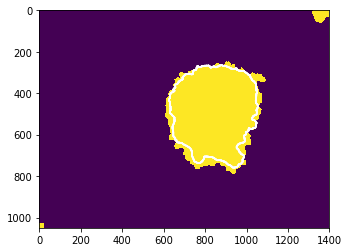

In [29]:
# model_seg, _, _, _ = seg_pipe.train_classif_color2d_slic_features([img_red], [annot], DICT_FEATURES, sp_size=SLIC_SIZE, sp_regul=SLIC_REGUL)
segm_gc, _ = seg_pipe.segment_color2d_slic_features_model_graphcut(img_tf, model_seg, DICT_FEATURES, sp_size=SLIC_SIZE, sp_regul=SLIC_REGUL, gc_edge_type='color', gc_regul=20.)

_= plt.imshow(segm_gc), plt.contour(annot, colors='w')
# plt.subplot(1, 2, 2), plt.imshow(seg_soft[:, :, 1])

In [24]:
from IPython.html import widgets
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Region growing - GraphCut

['shifts', 'lut_data_cost', 'lut_shape_cost', 'criteria', 'labels', 'centres']


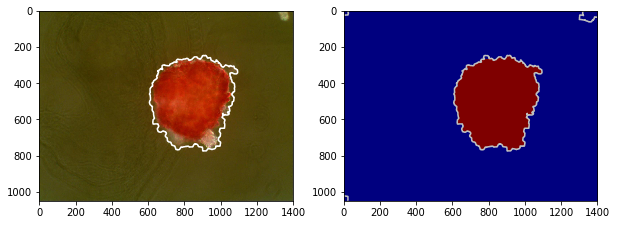

In [26]:
debug_gc_mm = {}
labels_gc = seg_rg.region_growing_shape_slic_graphcut(slic, slic_prob_fg, centers, (model_rg, list_mean_cdf), 'set_cdfs', 
                coef_shape=2., coef_pairwise=5., prob_label_trans=[0.1, 0.03], optim_global=False, 
                allow_obj_swap=False, dict_thresholds=seg_rg.RG2SP_THRESHOLDS, nb_iter=100, debug_history=debug_gc_mm)
segm_obj = labels_gc[slic]
print (debug_gc_mm.keys())

fig = plt.figure(figsize=(10, 4))
_= plt.subplot(1, 2, 1), plt.imshow(img), plt.contour(segm_obj, levels=np.unique(segm_obj), colors='w')
_= plt.subplot(1, 2, 2), plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(segm_gc, levels=np.unique(segm_gc), colors='#bfbfbf')

Interastive visualisation - over iterations

<function __main__.show_partial>

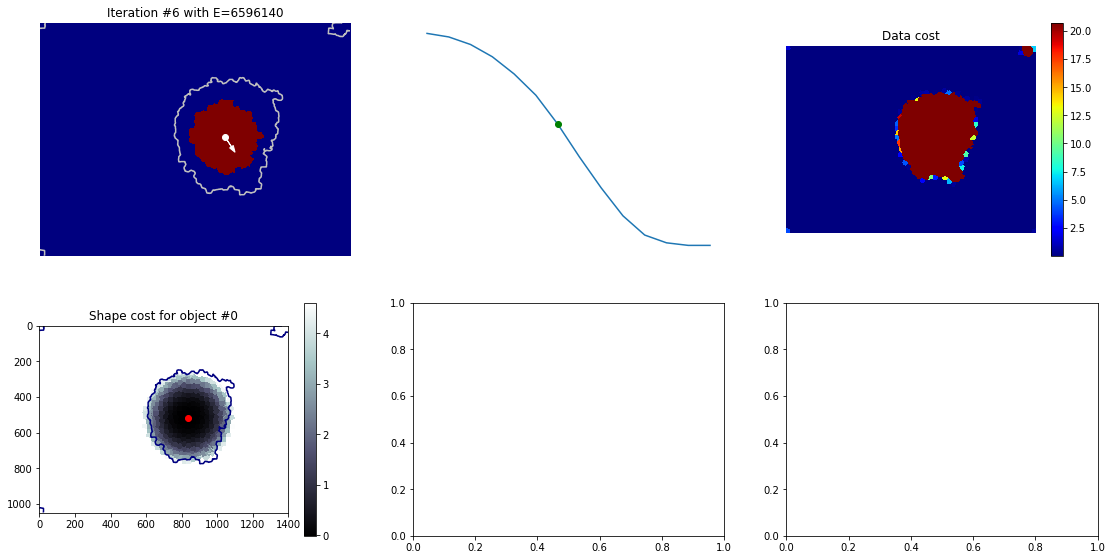

In [27]:
def show_partial(i):
    _= plt.close(), tl_visu.figure_rg2sp_debug_complete(segm_gc, slic, debug_gc_mm, i, max_size=5)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gc_mm['criteria']) -1))